In [87]:
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate, iradon
import cv2
import numpy as np
from tqdm import tqdm
import polars as pl
import time

In [50]:
_pth = os.path.join(os.path.dirname(os.getcwd()), 'dataset', '2')
# _pth = r'F:\EPID Images\cube\854320164'

_files = os.listdir(_pth)

In [51]:
dcm = dcmread(os.path.join(_pth, _files[0]))

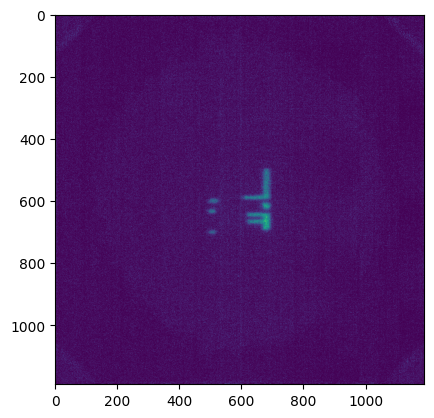

In [52]:
plt.imshow(dcm.pixel_array)

In [54]:
dcm.pixel_array

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [1, 0, 4, ..., 3, 0, 0],
       [3, 0, 2, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint16)

In [99]:
g_angle = []
_images = np.zeros((1190, 1190,len(_files)), dtype=np.uint16)
prev = np.zeros((1190, 1190), dtype=np.uint16)
curr = np.zeros((1190, 1190), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    _m = curr - prev
    if np.min(_m) > 10000:
        _images[ :, :,idx] = _images[:, :, idx-1]
        g_angle.append(g_angle[idx-1])
    else:        
        _m[_m<10] = 0
        _images[ :, :, idx] = _m
        prev = curr
        g_angle.append(raw.GantryAngle)

100%|██████████| 580/580 [00:15<00:00, 36.78it/s]


In [101]:
g_angle = np.array(g_angle)

In [102]:
# _recons_x = []
_recons_y = []
for i in tqdm(np.arange(0, _images.shape[0], 30)):
    # _recons_x.append(iradon(_images[i, :, :], theta=g_angle, circle=False, filter_name='ramp'))
    _recons_y.append(iradon(_images[:, i, :], theta=g_angle, circle=False, filter_name='ramp'))

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [04:21<00:00,  6.54s/it]


In [98]:
for i, j in zip(_recons_x, _recons_y):
    time.sleep(0.5)

    cv2.imshow('img', np.concatenate((i, j), axis=1))
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [103]:
for i in _recons_y:
    time.sleep(0.5)

    cv2.imshow('img', i)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [104]:
import cupy as cp

In [105]:
sinogram_cpu = cp.asnumpy(_images[590, :, :])

In [106]:
iradon(sinogram_cpu, theta=g_angle, circle=False, filter_name='ramp')

array([[ 0.1939095 ,  0.1747584 ,  0.20462991, ...,  0.7482639 ,
         0.76329963,  0.91845496],
       [ 0.21286382,  0.3136978 ,  0.17262938, ...,  0.96799131,
         0.94585857,  1.22521855],
       [ 0.07327774,  0.10712472, -0.10714357, ...,  0.86597432,
         0.8866971 ,  0.94990757],
       ...,
       [ 0.6717594 ,  0.74380316,  0.66366997, ...,  0.19121663,
         0.37799199,  0.33224159],
       [ 1.21873207,  1.05790498,  1.05879072, ..., -0.00881096,
         0.1993612 ,  0.28063315],
       [ 0.880093  ,  0.81495767,  0.98209964, ...,  0.28694057,
         0.07125181,  0.42724837]])

In [107]:
sinogram_cpu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)